In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl 
import plotly.plotly as py
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
data = pd.read_fwf('samples/11.0111_81050103.txt', header=None, names = ["x", "y", "u"],widths=[21,30,35])
data.shape

(5000, 3)

In [3]:
data.head()

,x,y,u
0,5.000000e-07,5.000000e-07,10.334715
1,1.500000e-06,5.000000e-07,9.021829
2,2.500000e-06,5.000000e-07,7.748682
3,3.500000e-06,5.000000e-07,6.511245
4,4.500000e-06,5.000000e-07,5.908123


In [4]:
data.dtypes

x    float64
y    float64
u    float64
dtype: object

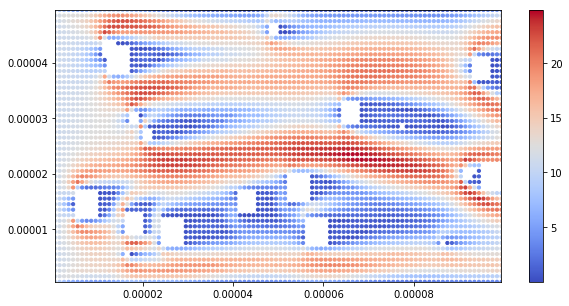

In [5]:
plt.figure(figsize=(10, 5))
cm = mpl.cm.get_cmap('coolwarm')
sc = plt.scatter(data.x, data.y, c=data.u, vmin=min(data.u), vmax=max(data.u), s= 10, cmap=cm) 
plt.colorbar(sc) 
plt.xlim(min(data.x), max(data.x))
plt.ylim(min(data.y), max(data.y))
plt.show() 

nodes inside the walls are marked by NULL in 'u'

In [6]:
sum(data.u.isnull())

239

In [7]:
data['walls'] = data.u
data.walls[~data.walls.isnull()] = 0
data.walls[ data.walls.isnull()] = 1

# velocity is zero inside the walls
data.u[data.u.isnull()] = 0

In [19]:
x = data.x.values.reshape(50,100)
y = data.y.values.reshape(50,100)
u = data.u.values.reshape(50,100)
walls = data.walls.values.reshape(50,100)

In [20]:
x.shape

(50, 100)

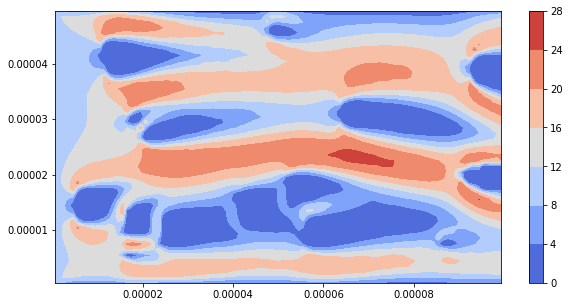

In [21]:
plt.figure(figsize=(10, 5))
cm = mpl.cm.get_cmap('coolwarm')
g = plt.contourf(x, y, u, cmap=cm)
g = plt.colorbar(g)

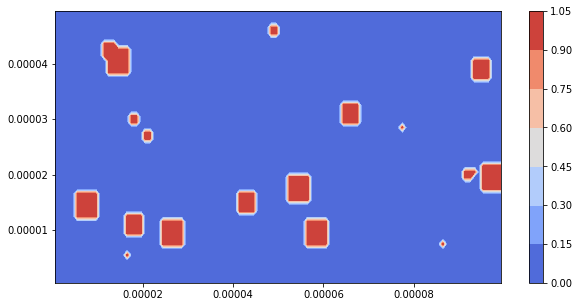

In [22]:
plt.figure(figsize=(10, 5))
cm = mpl.cm.get_cmap('coolwarm')
g = plt.contourf(x, y, walls, cmap=cm)
g = plt.colorbar(g)